In [5]:
import pandas as pd
from pathlib import Path
import tqdm
import numpy as np
import librosa

from pytube import Channel, YouTube
import torch

# Dataset creation

## Data entries

In [6]:
channel_url = "https://www.youtube.com/channel/UCGeBogGDZ9W3dsGx-mWQGJA"

channel = Channel(channel_url)
channel.channel_name, len(channel), channel.channel_id

('IMPAULSIVE', 337, 'UCGeBogGDZ9W3dsGx-mWQGJA')

In [21]:
video_attributes_name = ("title", "video_id", "watch_url", "length", "publish_date", "thumbnail_url", "author", "channel_id", "channel_url", "description", "keywords")
video_attributes = {attr: [] for attr in video_attributes_name}

channel_dataframes_path = Path(".").resolve().parent / "dataset" / "full" / (channel.channel_id + ".pkl")

if not channel_dataframes_path.is_file():
    video: YouTube
    for video in tqdm.notebook.tqdm(channel.videos):
        video.check_availability()
        for attr in video_attributes_name:
            video_attributes[attr].append(getattr(video, attr))

    channel_dataframes = pd.DataFrame(video_attributes)
    channel_dataframes.to_pickle(Path(".") / "dataset" / (channel.channel_id + ".pkl"))

## Download audio sample

In [22]:
dataset_audio_sample_stream = channel.videos[0].streams.filter(type="audio", mime_type="audio/mp4", abr="48kbps").first()
dataset_audio_sample_path = Path(".").resolve() / "dataset" / "samples" / f"{channel.videos[0].video_id}.mp4"

print(f"\nDownload stream {dataset_audio_sample_stream} at {dataset_audio_sample_path}")
dataset_audio_sample_stream.download(
    output_path = dataset_audio_sample_path.parent,
    filename = dataset_audio_sample_path.name
)


Download stream <Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio"> at /home/arthur/workspace/adversarial-transformer-clipper/notebooks/dataset/samples/QFCeGMJHem0.mp4


'/home/arthur/workspace/adversarial-transformer-clipper/notebooks/dataset/samples/QFCeGMJHem0.mp4'

In [23]:
dataset_audio_sample_rate = 44_100
dataset_audio_sample_data, _ = librosa.load(dataset_audio_sample_path, duration=30, offset=25, sr=dataset_audio_sample_rate)

/home/arthur/workspace/adversarial-transformer-clipper/.env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


## Spectrogram

In [24]:
import torchaudio, matplotlib.pyplot as plt

In [25]:
def plot_spectrogram(spectrogram, title=None, ylabel='freq_bin', aspect='auto', xmax=None, hop_duration=None):
    fig, axs = plt.subplots(1, 1) # figsize=(30, 5)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spectrogram), origin='lower', aspect=aspect, interpolation='nearest')
    if hop_duration is not None:
        axs.xaxis.set_major_formatter(lambda value, tick_number: f"{(value*hop_duration):.1f}")
        axs.set_xlabel('seconds')
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs, format='%+2.0f dB')
    plt.show(block=False)

/home/arthur/workspace/adversarial-transformer-clipper/.env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


torch.Size([30, 128, 101])


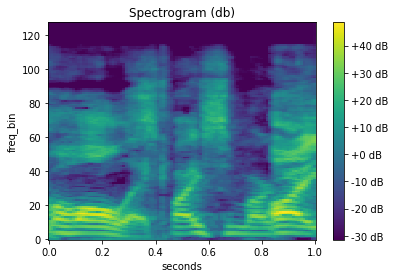

In [27]:
from dataclasses import dataclass, asdict, field
from typing import Optional
from pathlib import Path
import torchaudio

@dataclass
class AudioFrameLoaderConfig:
    frame_rate: float = 1.0
    sampling_rate: int = 44_100
    hop_length: int = 441
    win_length: int = 2024
    n_mels: int = 128
    n_fft: int = 4096
    f_max: Optional[int] = None
    hop_duration: float = field(init=False)
    wave_frame_length: int = field(init=False)

    def __post_init__(self):
        self.hop_duration = self.hop_length/self.sampling_rate
        self.wave_frame_length = int(self.sampling_rate//self.frame_rate)

class AudioFrameLoader():
    def __init__(self, config: AudioFrameLoaderConfig = AudioFrameLoaderConfig()) -> None:
        self.config = config
        self.spectrogramer = torchaudio.transforms.MelSpectrogram(
            hop_length=config.hop_length,
            win_length=config.win_length,
            n_mels=config.n_mels,
            n_fft=config.n_fft,
            f_max=config.f_max,
            center=True,
            pad_mode="reflect",
            # power=2.0,
        )

    def __call__(self, audio_file_path: Path, duration: int, offset: int = 0):
        audio_wave, _ = librosa.load(audio_file_path, duration=30, offset=25, sr=self.config.sampling_rate)
        audio_wave = torch.tensor(audio_wave)
        # print(audio_wave.shape, self.config.wave_frame_length)
        # audio_wave = torch.stack(audio_wave.split(self.config.wave_frame_length))
        audio_spectrograms = []
        for audio_wave_frame in audio_wave.split(self.config.wave_frame_length):
            audio_spectrograms.append(self.spectrogramer(audio_wave_frame))
        audio_spectrograms = torch.stack(audio_spectrograms)
        return audio_spectrograms

audio_frame_loader = AudioFrameLoader(AudioFrameLoaderConfig(frame_rate=1))
spectrograms = audio_frame_loader(audio_file_path = dataset_audio_sample_path, duration = 30)

print(spectrograms.shape)
plot_spectrogram(spectrograms[0], hop_duration=audio_frame_loader.config.hop_duration)

hop_duration=0.011609977324263039s
mel_spectrogram.shape=torch.Size([128, 2584])


/home/arthur/workspace/adversarial-transformer-clipper/.env/lib/python3.8/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


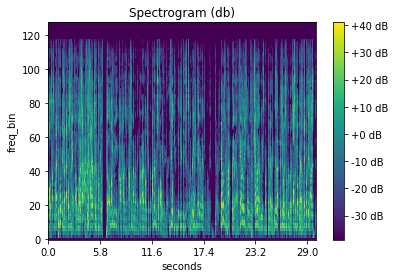

In [28]:
n_fft = 1024
win_length = n_fft # i.e. Default
hop_length = n_fft // 2 # i.e. Default
sample_rate = dataset_audio_sample_rate

spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
hop_duration=hop_length/sample_rate

# Perform transformation
waveform = torch.tensor(dataset_audio_sample_data) # torchaudio.load(dataset_audio_sample_path, normalize=True)
mel_spectrogram = spectrogram(waveform)

print(f"{hop_duration=}s\n{mel_spectrogram.shape=}")
plot_spectrogram(mel_spectrogram, hop_duration=hop_duration)

# Model creation

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA not detected")

NVIDIA GeForce RTX 2060 with Max-Q Design


### Custom ResNet

In [29]:
import sys
from pathlib import Path
sys.path.append(str(Path(".").resolve().parent))
from adversarial_transformer_clipper.model.audio_features import ResNet

In [37]:
resnet18 = ResNet(layers=[2, 2, 2, 2], num_classes=1024, input_filter=1)
output = resnet18(spectrograms.unsqueeze(dim=1))
output.shape

torch.Size([30, 1024])

### Speech2Text

In [ ]:
import torch
from pathlib import Path
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration
from datasets import load_dataset
import soundfile as sf

device = torch.device("cuda")

small_model_name = "facebook/s2t-small-librispeech-asr"
medium_model_name = "facebook/s2t-medium-librispeech-asr"
model = Speech2TextForConditionalGeneration.from_pretrained(small_model_name).to(device)
processor = Speech2TextProcessor.from_pretrained(small_model_name)

def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

ds = load_dataset(
    "patrickvonplaten/librispeech_asr_dummy",
    "clean",
    split="validation"
)
ds = ds.map(map_to_array)

input_features = processor(
    # ds["speech"][0],
    dataset_audio_sample_data,
    sampling_rate=dataset_audio_sample_rate,
    return_tensors="pt"
).input_features  # Batch size 1
# sf.write(file=Path(".") / "audio_test.wav", data=ds["speech"][0], samplerate=dataset_audio_sample_rate)

generated_ids = model.generate(input_features.to(device))
print(generated_ids.shape)
transcription = processor.batch_decode(generated_ids)
transcription


Reusing dataset librispeech_asr_dummy (/home/arthur/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr_dummy/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc)
Loading cached processed dataset at /home/arthur/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr_dummy/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc/cache-8a8433b3bbe68d1e.arrow
/home/arthur/workspace/adversarial-transformer-clipper/.env/lib/python3.8/site-packages/transformers/models/speech_to_text/modeling_speech_to_text.py:561: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths = (input_lengths - 1) // 2 + 1

torch.Size([1, 58])


["if i knows it's the last video that i posted on my utuetu was like locobolos as a broom of miles you're never come to cayley with a caleon during this show can you gauge"]

In [ ]:
model

Speech2TextForConditionalGeneration(
  (model): Speech2TextModel(
    (encoder): Speech2TextEncoder(
      (conv): Conv1dSubsampler(
        (conv_layers): ModuleList(
          (0): Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))
          (1): Conv1d(512, 512, kernel_size=(5,), stride=(2,), padding=(2,))
        )
      )
      (embed_positions): Speech2TextSinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0): Speech2TextEncoderLayer(
          (self_attn): Speech2TextAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=256, out_

### Wav2Vec2

In [ ]:
# !pip install transformers
# !pip install datasets
import soundfile as sf
import torch
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# load pretrained model
device = torch.device("cuda")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.to(device)

librispeech_samples_ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")

# load audio
# audio_input, sample_rate = sf.read(librispeech_samples_ds[0]["file"])
# audio_input, sample_rate = sf.read(dataset_audio_sample_path)
# audio_input = audio_input[:17416]
# sf.write(file=Path(".") / "audio_test.wav", data=audio_input, samplerate=sample_rate)

# pad input values and return pt tensor
audio = torch.from_numpy(dataset_audio_sample_data).float().to(device)
input_values = processor(audio, sampling_rate=dataset_audio_sample_rate, return_tensors="pt").input_values.to(device)

# INFERENCE

# retrieve logits & take argmax
outputs = model.wav2vec2(input_values)
logits = model.lm_head(model.dropout(outputs[0]))
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe
transcription = processor.decode(predicted_ids[0])

transcription

# # FINE-TUNE

# target_transcription = "A MAN SAID TO THE UNIVERSE I EXIST"

# # encode labels
# with processor.as_target_processor():
#   labels = processor(target_transcription, return_tensors="pt").input_ids

# # compute loss by passing labels
# loss = model(input_values, labels=labels).loss
# loss.backward()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Reusing dataset librispeech_asr_dummy (/home/arthur/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr_dummy/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc)


"I KNOWS IS SIR THE LAST VIDIO THAT I POSTED A MA UTO WAS LIKE OGOPOLOES AS A ROOM IN MY HOUSE YOU'RE NEVER COME TO GALIN GALIN DURING THI SHOL  YOU GAGE OUT OF MY NOWS I HATE THIS KIT"

In [ ]:
print(input_values.shape, "\n\n", model)

torch.Size([1, 240000]) 

 Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,

In [ ]:
input_values.shape, outputs[0].shape

(torch.Size([1, 480000]), torch.Size([1, 1499, 768]))